In [1]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df_podcast = pd.read_pickle('../data/podcast_df_040423.pkl')

In [3]:
df_podcast.head()

,title,producer,genre,description,num_episodes,avg_rating,num_reviews,link,episode_descriptions,itunes_id,rating,user
0,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1526579247,5,RobinFerris
1,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1526579247,1,Pops.99
2,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1526579247,5,ReddEye81
3,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1526579247,2,Keyta7777
4,One Strange Thing: Paranormal & True-Weird Mys...,One Strange Thing,History,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1526579247,4,Okkupent


In [4]:
df_podcast_enc = df_podcast.copy()

In [5]:
# Encode user data
encoder_user = OrdinalEncoder(dtype='int')
encoder_user.fit(df_podcast_enc[['user']])
df_podcast_enc[['user']] = encoder_user.transform(df_podcast_enc[['user']])

In [6]:
# Encode genre data
encoder_genre = OrdinalEncoder(dtype='int')
encoder_genre.fit(df_podcast_enc[['genre']])
df_podcast_enc[['genre']] = encoder_genre.transform(df_podcast_enc[['genre']])

In [7]:
# Encode itunes_id data
encoder_podcast = OrdinalEncoder(dtype='int')
encoder_podcast.fit(df_podcast_enc[['itunes_id']])
df_podcast_enc[['itunes_id']] = encoder_podcast.transform(df_podcast_enc[['itunes_id']])

In [8]:
# Encode producer data
encoder_producer = OrdinalEncoder(dtype='int')
encoder_producer.fit(df_podcast_enc[['producer']])
df_podcast_enc[['producer']] = encoder_producer.transform(df_podcast_enc[['producer']])

In [9]:
df_podcast_enc.head()

,title,producer,genre,description,num_episodes,avg_rating,num_reviews,link,episode_descriptions,itunes_id,rating,user
0,One Strange Thing: Paranormal & True-Weird Mys...,1782,7,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1821,5,22200
1,One Strange Thing: Paranormal & True-Weird Mys...,1782,7,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1821,1,21031
2,One Strange Thing: Paranormal & True-Weird Mys...,1782,7,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1821,5,21816
3,One Strange Thing: Paranormal & True-Weird Mys...,1782,7,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1821,2,14504
4,One Strange Thing: Paranormal & True-Weird Mys...,1782,7,"Paranormal, unexplainable, and uncanny stories...",105,4.6,499.0,https://podcasts.apple.com/us/podcast/one-stra...,[In celebration of our new premium format—two ...,1821,4,20018


In [10]:
X = df_podcast_enc.loc[:,['user', 'itunes_id', 'genre', 'producer']] #'num_episodes','avg_rating','num_reviews'
y = df_podcast_enc.loc[:,'rating']

# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=41, test_size=0.5)

In [11]:
def prep_dataloaders(X_train, y_train, X_val, y_val, batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

In [12]:
batchsize = 64
trainloader,valloader = prep_dataloaders(X_train, y_train, X_val, y_val, batchsize)

In [13]:
class NNHybridFiltering(nn.Module):
    
    def __init__(self, n_users, n_podcasts, n_genres, n_producers, embdim_users, embdim_podcasts, embdim_genres, embdim_producers, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embdim_users)
        self.podcast_embeddings = nn.Embedding(num_embeddings=n_podcasts,embedding_dim=embdim_podcasts)
        self.genre_embeddings = nn.Embedding(num_embeddings=n_genres,embedding_dim=embdim_genres)
        self.producer_embeddings = nn.Embedding(num_embeddings=n_producers,embedding_dim=embdim_producers)
        self.fc1 = nn.Linear(embdim_users+embdim_podcasts+embdim_genres+embdim_producers,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_podcasts = self.podcast_embeddings(X[:,1])
        embedded_genres = self.genre_embeddings(X[:,2])
        embedded_producers = self.producer_embeddings(X[:,3])
        # Concatenate user, podcast, genre, and producer embeddings
        embeddings = torch.cat([embedded_users,embedded_podcasts,embedded_genres,embedded_producers],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds

In [14]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [16]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'user'].max()+1
n_podcast = X.loc[:,'itunes_id'].max()+1
n_genres = X.loc[:,'genre'].max()+1
n_producers = X.loc[:,'producer'].max()+1
model = NNHybridFiltering(n_users,
                          n_podcast,
                          n_genres,
                          n_producers,
                          embdim_users=50,
                          embdim_podcasts=25, 
                          embdim_genres=5,
                          embdim_producers=25,
                          n_activations=50,
                          rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.0001
n_epochs=15
#wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)

Epoch 0/14
----------
train loss: 1.8570
val loss: 1.6394
Epoch 1/14
----------
train loss: 1.5127
val loss: 1.4213
Epoch 2/14
----------
train loss: 1.3713
val loss: 1.3387
Epoch 3/14
----------
train loss: 1.3186
val loss: 1.3088
Epoch 4/14
----------
train loss: 1.2981
val loss: 1.2973
Epoch 5/14
----------
train loss: 1.2882
val loss: 1.2917
Epoch 6/14
----------
train loss: 1.2812
val loss: 1.2890
Epoch 7/14
----------
train loss: 1.2763
val loss: 1.2872
Epoch 8/14
----------
train loss: 1.2720
val loss: 1.2861
Epoch 9/14
----------
train loss: 1.2674
val loss: 1.2853
Epoch 10/14
----------
train loss: 1.2632
val loss: 1.2846
Epoch 11/14
----------
train loss: 1.2582
val loss: 1.2840
Epoch 12/14
----------
train loss: 1.2538
val loss: 1.2840
Epoch 13/14
----------
train loss: 1.2483
val loss: 1.2834
Epoch 14/14
----------
train loss: 1.2436
val loss: 1.2837
Training complete in 0m 15s


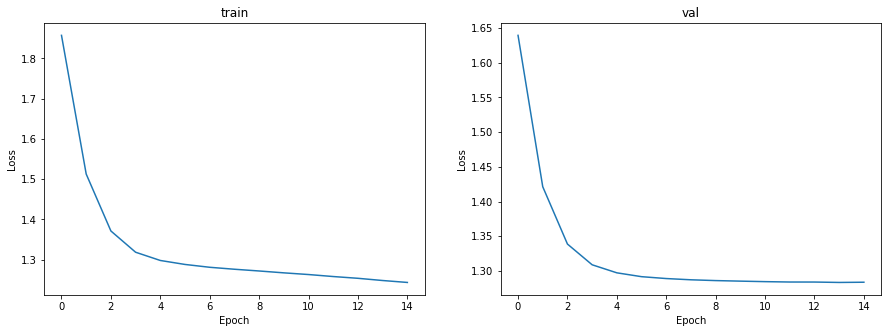

In [17]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

In [18]:
def predict_rating(model, userId, itunesId, genre, producer, user_encoder, genre_encoder, podcast_encoder, producer_encoder, device):
    # Encode all data
    genre = genre_encoder.transform(np.array(genre).reshape(-1, 1))
    itunesId = podcast_encoder.transform(np.array(itunesId).reshape(-1, 1))
    userId = user_encoder.transform(np.array(userId).reshape(-1, 1))
    producer = producer_encoder.transform(np.array(producer).reshape(-1, 1))
    # Get predicted rating
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        X = torch.Tensor([userId,itunesId,genre,producer]).long().view(1,-1)
        X = X.to(device)
        pred = model.forward(X)
        return pred

# Get the predicted rating for a random user-item pair
rating = predict_rating(model,userId='gcvds',itunesId='1143630029',genre='Technology',producer='WIRED',user_encoder=encoder_user, genre_encoder=encoder_genre, podcast_encoder=encoder_podcast, producer_encoder=encoder_producer, device=device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))

Predicted rating is 3.7


<ipython-input-18-f7fd6525298b>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  X = torch.Tensor([userId,itunesId,genre,producer]).long().view(1,-1)


In [19]:
def generate_recommendations(podcasts,model,userId,user_encoder,genre_encoder,podcast_encoder,producer_encoder,device):
    # Create progress bar
    pbar = tqdm(total=len(podcasts))
    # Get predicted ratings for every podcast
    pred_ratings = []
    for podcast in podcasts['itunes_id'].tolist():
        genre = podcasts.loc[podcasts['itunes_id']==podcast,'genre'].values[0]
        producer = podcasts.loc[podcasts['itunes_id']==podcast,'producer'].values[0]
        pred = predict_rating(model,userId,podcast,genre,producer,user_encoder,genre_encoder,podcast_encoder,producer_encoder,device)
        pred_ratings.append(pred.detach().cpu().item())
        pbar.update()
    pbar.close()
    print("Completed inferencing")
    # Sort movies by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    recs = podcasts.iloc[idxs]['itunes_id'].values.tolist()
    # Filter out podcasts already listened to by user
    podcasts_listened = podcasts.loc[podcasts['user']==userId, 'itunes_id'].tolist()
    recs = [rec for rec in recs if not rec in podcasts_listened]
    # Filter to top 5 recommendations
    recs = recs[:5]
    # Convert itunes_id to titles
    recs_names = []
    for rec in recs:
        recs_names.append(podcasts.loc[podcasts['itunes_id']==rec,'title'].values[0])
    return recs_names


In [20]:
# Get recommendations for a random user
df_podcast_uniq = df_podcast.drop_duplicates(subset=["itunes_id"],keep="first").reset_index(drop=True)
userId = 'gcvds'
recs = generate_recommendations(df_podcast_uniq,model,userId,encoder_user,encoder_genre,encoder_podcast,encoder_producer,device)
for i,rec in enumerate(recs):
    print('Recommendation {}: {}'.format(i,rec))

100%|██████████| 3936/3936 [03:25<00:00, 19.14it/s]

Completed inferencing
Recommendation 0: Actions Detrimental with Denny Hamlin
Recommendation 1: Believing the Bizarre: Paranormal Conspiracies & Myths
Recommendation 2: The Counsel of Trent
Recommendation 3: Kwik Brain with Jim Kwik
Recommendation 4: R&B Money
